In [56]:
%matplotlib inline
import os
import sys
import functools
from collections import Counter
import pylab as plt
import numpy as np
import fitsio
from astrometry.util.fits import fits_table, merge_tables
from astrometry.util.util import Tan
from astrometry.util.starutil_numpy import degrees_between
from astrometry.util.plotutils import plothist
from astrometry.libkd.spherematch import match_radec, tree_build_radec, tree_search_radec, tree_open
sys.path.insert(0, 'legacypipe/py')
from legacypipe.gaiacat import GaiaCatalog
from legacypipe.reference import fix_tycho, fix_gaia, merge_gaia_tycho
os.environ['GAIA_CAT_DIR'] = '/global/cfs/cdirs/cosmo/work/gaia/chunks-gaia-dr2-astrom-2/'

In [2]:
#tiles = fits_table('/global/cfs/cdirs/desi/users/djschleg/tiling/tiles-4112packing-2021-03-28.fits')
#tiles = fits_table('/global/cfs/cdirs/desi/users/schlafly/tiling/tiles-4112-packing-20210322-decorated.fits')

#tag = '4112-packing-20210328'
tag = '4112-packing-20210329'

tiles = fits_table('/global/cfs/cdirs/desi//users/schlafly/tiling/tiles-%s-decorated.fits' % tag)

In [3]:
tiles.about()

tabledata object with 94576 rows and 21 columns:
   brightdec (<class 'numpy.ndarray'>) shape (94576, 3) dtype >f8
   brightra (<class 'numpy.ndarray'>) shape (94576, 3) dtype >f8
   brightvtmag (<class 'numpy.ndarray'>) shape (94576, 3) dtype >f4
   centerid (<class 'numpy.ndarray'>) shape (94576,) dtype >i8
   dec (<class 'numpy.ndarray'>) shape (94576,) dtype >f8
   ebv_med (<class 'numpy.ndarray'>) shape (94576,) dtype >f4
   imagefrac_g (<class 'numpy.ndarray'>) shape (94576,) dtype >f4
   imagefrac_gr (<class 'numpy.ndarray'>) shape (94576,) dtype >f4
   imagefrac_grz (<class 'numpy.ndarray'>) shape (94576,) dtype >f4
   imagefrac_r (<class 'numpy.ndarray'>) shape (94576,) dtype >f4
   imagefrac_z (<class 'numpy.ndarray'>) shape (94576,) dtype >f4
   in_desi (<class 'numpy.ndarray'>) shape (94576,) dtype bool
   in_imaging (<class 'numpy.ndarray'>) shape (94576,) dtype bool
   lst_design (<class 'numpy.ndarray'>) shape (94576,) dtype >f4
   pass (<class 'numpy.ndarray'>) shape (9

In [4]:
if False:
    plt.plot(tiles.centerid);
    plt.show()
    plt.plot(tiles.get('pass'));

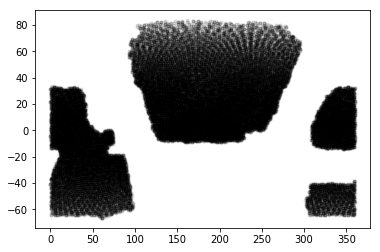

In [5]:
I = np.flatnonzero(tiles.in_imaging)
plt.plot(tiles.ra[I], tiles.dec[I], 'k.', alpha=0.1);

In [6]:
F = fitsio.FITS('desi/spectro/data/20210328/00082600/focus-00082600.fits.fz')
G = fitsio.FITS('desi/spectro/data/20210328/00082600/guide-00082600-0000.fits.fz')

In [7]:
focus_hdumap = {}
for i,f in enumerate(F):
    e = f.get_extname()
    if e.startswith('FOCUS'):
        e = e[5:]
        if len(e) == 1:
            n = int(e)
            focus_hdumap[n] = i
guide_hdumap = {}
for i,f in enumerate(G):
    e = f.get_extname()
    if e.startswith('GUIDE'):
        e = e[5:]
        if len(e) == 1:
            try:
                n = int(e)
                guide_hdumap[n] = i
            except ValueError:
                continue
focus_hdumap, guide_hdumap

({9: 1, 4: 3, 1: 5, 6: 7}, {8: 2, 3: 3, 0: 4, 7: 5, 2: 6, 5: 7})

In [8]:
all_wcs = {}
for chip,hdu in guide_hdumap.items():
    hdr = G[hdu].read_header()
    wcs = Tan(hdr)
    all_wcs[('GUIDE', chip)] = wcs

In [9]:
hdr = G['GUIDER'].read_header()
skyra = hdr['SKYRA']
skydec = hdr['SKYDEC']

GUIDE 8 -> angle  -32.94 , deltal/36  7.9914 dist 5662.7
GUIDE 3 -> angle  146.91 , deltal/36  2.9955 dist 5675.1
GUIDE 0 -> angle -105.04 , deltal/36 -0.0057 dist 5660.4
GUIDE 7 -> angle    3.09 , deltal/36  6.9906 dist 5668.1
GUIDE 2 -> angle -177.11 , deltal/36  1.9961 dist 5669.9
GUIDE 5 -> angle   75.04 , deltal/36  4.9921 dist 5677.8
FOCUS 9 -> angle  -69.11 , deltal/36  8.9961 dist 5669.4
FOCUS 4 -> angle  110.60 , deltal/36  4.0042 dist 5664.3
FOCUS 1 -> angle -141.48 , deltal/36  1.0064 dist 5675.0
FOCUS 6 -> angle   38.99 , deltal/36  5.9933 dist 5658.5


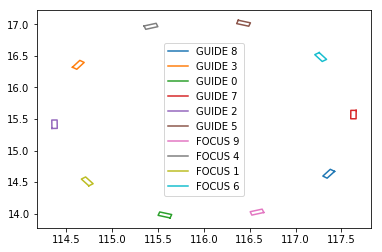

In [43]:
# Angle corresponding to GUIDE0
t0 = -105.25

rel_xy = {}

# Fake tile WCS headers, used to represent positions on focal plane.
# Note that we put CRPIX on 0 so we can use 0-based x,y coords for angles.
cd = 1./3600.
tilewcs = Tan(skyra, skydec, 0., 0., -cd, 0., 0., cd, 1000., 1000.)
ztilewcs = Tan(0., 0., 0., 0., -cd, 0., 0., cd, 1000., 1000.)

dists = []
for k,wcs in all_wcs.items():
    (gstr,gnum) = k
    h,w = wcs.shape
    rc,dc = wcs.crval
    # For the GUIDE/FOCUS chip centers/angles, we record the pixel positions tx,ty in our fake tile WCS frame.
    ok,tx,ty = tilewcs.radec2pixelxy(rc, dc)
    angle = np.arctan2(ty, -tx)
    dra,ddec = ztilewcs.pixelxy2radec(tx, ty)
    #print('dra,ddec %6.3f, %6.3f, angle %6.2f' % (dra, ddec, np.rad2deg(angle)))

    dist = degrees_between(skyra, skydec, rc, dc)
    n = ((t0 - np.rad2deg(angle))/36.)
    if n < -0.5:
        n += 10.        
    print(gstr,gnum, '-> angle %7.2f' % np.rad2deg(angle), ', deltal/36 %7.4f' % n, 'dist %.1f' % (3600.*dist))
    dists.append(dist)

    # Save the WCS for the CD matrix and CRPIX
    rel_xy[k] = (tx, ty, Tan(wcs))
    
    x,y = [1,1,w,w,1],[1,h,h,1,1]
    r,d = wcs.pixelxy2radec(x, y)
    plt.plot(r, d, '-', label='%s %i' % (gstr, gnum))

plt.legend();

In [44]:
# Initially place the FOCUS chips at the average GUIDE radius
avgr = np.mean([np.hypot(x,y) for k,(x,y,w) in rel_xy.items()])

for chip,hdu in focus_hdumap.items():
    hdr = F[hdu].read_header()

    n = chip
    angle = np.deg2rad(t0 - n * 36)

    tx = -avgr * np.cos(angle)
    ty =  avgr * np.sin(angle)

    # don't really need this (except for plot below)
    ra,dec = tilewcs.pixelxy2radec(tx, ty)
    
    info = F[hdu].get_info()
    (_,h,w) = info['dims']
    hdr['CRVAL1'] = ra
    hdr['CRVAL2'] = dec
    hdr['CRPIX1'] = (w+1.)/2.
    hdr['CRPIX2'] = (h+1.)/2.
    wcs = Tan(hdr)
    k = ('FOCUS', chip)
    
    rel_xy[k] = (tx, ty, wcs)

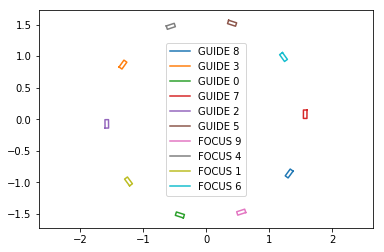

In [57]:
maxr = 0.

for k,(tx,ty,wcs) in rel_xy.items():
    (gstr,gnum) = k
    h,w = wcs.shape
    r,d = ztilewcs.pixelxy2radec(tx, ty)
    x,y = [1,1,w,w,1],[1,h,h,1,1]
    wcs.set_crval(r, d)
    r,d = wcs.pixelxy2radec(x, y)
    dists = degrees_between(0., 0., r, d)
    maxr = max(maxr, max(dists))
    r[r>180] -= 360.
    plt.plot(r, d, '-', label='%s %i' % (gstr, gnum))
plt.legend();
plt.axis('equal');

In [50]:
wcs.pixel_scale()

0.2043695146088085

In [48]:
all_sub_wcs = {}
for (cstr,cnum),(tx,ty,wcs) in rel_xy.items():
    if cstr == 'FOCUS':
        # add the two half-chips.
        # wcs.get_subimage moves the CRPIX, but leave CRVAL unchanged, so tx,ty still work unchanged.
        all_sub_wcs[(cstr, cnum, 1)] = (tx, ty, wcs.get_subimage(50, 1, 1024, 1032))
        all_sub_wcs[(cstr, cnum, 2)] = (tx, ty, wcs.get_subimage(1174, 1, 1024, 1032))
        # Add (negative) margin for donut size and telescope pointing uncertainty.
        # ~10" for donuts and ~10" for telescope pointing
        margin = 100
        all_sub_wcs[(cstr, cnum, -1)] = (tx, ty, wcs.get_subimage(50+margin, 1+margin, 1024-2*margin, 1032-2*margin))
        all_sub_wcs[(cstr, cnum, -2)] = (tx, ty, wcs.get_subimage(1174+margin, 1+margin, 1024-2*margin, 1032-2*margin))
    else:
        all_sub_wcs[(cstr, cnum, 0)] = (tx, ty, wcs)
        # Add expanded GUIDE chips -- 25" margin / 0.2"/pix = 125 pix
        margin = 125
        h,w = wcs.shape
        all_sub_wcs[(cstr, cnum, -1)] = (tx, ty, wcs.get_subimage(-margin, -margin, w+2*margin, h+2*margin))

In [17]:
# 12,000,000 of your brightest friends
#G = fits_table('/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/masking/gaia-mask-dr9.fits.gz')
#plt.hist(G.gaia_phot_g_mean_mag, bins=50, log=True);
#plt.hist(G.mag[G.ref_cat == 'G2'], bins=50, log=True, label='Gaia');
#plt.hist(G.mag[G.ref_cat == 'T2'], bins=50, log=True, histtype='step', lw=2, label='Tycho-2');
#plt.legend();
# Bright
#GB = G[G.mag < 18.]
#len(GB)
#gkd = tree_build_radec(ra=GB.ra, dec=GB.dec)

In [52]:
Nbright = 10
tiles_ann = fits_table()
#tiles_ann.centerid = tiles.centerid

keys = list(all_sub_wcs.keys())
keys.sort()
wcs_regions = []
for k in keys:
    tx,ty,wcs = all_sub_wcs[k]
    ctype,cnum,half = k
    if half == 0:
        name = '%s_%i' % (ctype.lower(), cnum)
    elif half == -1 and ctype=='GUIDE':
        # expanded guide
        name = '%s_%i_margin' % (ctype.lower(), cnum)
    elif half <= -1:
        # reduced focus
        name = '%s_%i_%s_margin' % (ctype.lower(), cnum, chr(ord('a')-1+np.abs(half)))
    else:
        name = '%s_%i_%s' % (ctype.lower(), cnum, chr(ord('a')-1+half))
    arr = np.zeros(len(tiles), (np.float32, Nbright))
    tiles_ann.set('brightest_'+name, arr)        
    wcs_regions.append((name, tx, ty, wcs, arr))

In [54]:
class CachingGaiaCatalog(GaiaCatalog):
    def __init__(self, columns=None, **kwargs):
        super().__init__(**kwargs)
        self.columns = columns

    def get_healpix_catalog(self, healpix):
        #return super().get_healpix_catalog(healpix)
        from astrometry.util.fits import fits_table
        fname = self.fnpattern % dict(hp=healpix)
        #print('Reading', fname)
        return fits_table(fname, columns=self.columns)

    def get_healpix_catalogs(self, healpixes):
        from astrometry.util.fits import merge_tables
        cats = []
        for hp in healpixes:
            cats.append(self.get_healpix_catalog(hp))
        if len(cats) == 1:
            return cats[0].copy()
        return merge_tables(cats)

    @functools.lru_cache(maxsize=4000)
    def get_healpix_tree(self, healpix):
        from astrometry.util.fits import fits_table
        fname = self.fnpattern % dict(hp=healpix)
        tab = fits_table(fname, columns=self.columns)
        kd = tree_build_radec(tab.ra, tab.dec)
        return (kd,tab)
    
    def get_healpix_rangesearch_catalogs(self, healpixes, rc, dc, rad):
        cats = []
        for hp in healpixes:
            (kd,tab) = self.get_healpix_tree(hp)
            I = tree_search_radec(kd, rc, dc, rad)
            if len(I):
                cats.append(tab[I])
        if len(cats) == 1:
            return cats[0] #.copy()
        return merge_tables(cats)
    
    def get_catalog_in_wcs(self, wcs, step=100., margin=10):
        # Grid the CCD in pixel space
        W,H = wcs.get_width(), wcs.get_height()
        xx,yy = np.meshgrid(
            np.linspace(1-margin, W+margin, 2+int((W+2*margin)/step)),
            np.linspace(1-margin, H+margin, 2+int((H+2*margin)/step)))
        # Convert to RA,Dec and then to unique healpixes
        ra,dec = wcs.pixelxy2radec(xx.ravel(), yy.ravel())
        healpixes = set()
        for r,d in zip(ra,dec):
            healpixes.add(self.healpix_for_radec(r, d))

        # Read catalog in those healpixes
        rc,dc = wcs.radec_center()
        rad = wcs.radius()
        cat = self.get_healpix_rangesearch_catalogs(healpixes, rc, dc, rad)
        
        # Cut to sources actually within the CCD.
        _,xx,yy = wcs.radec2pixelxy(cat.ra, cat.dec)
        cat.x = xx
        cat.y = yy
        onccd = np.flatnonzero((xx >= 1.-margin) * (xx <= W+margin) *
                               (yy >= 1.-margin) * (yy <= H+margin))
        cat.cut(onccd)
        return cat

gaia = CachingGaiaCatalog(columns=['ra','dec','phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'astrometric_excess_noise',
                                  'astrometric_params_solved', 'source_id', 'pmra_error', 'pmdec_error', 'parallax_error',
                                  'ra_error', 'dec_error', 'pmra', 'pmdec', 'parallax', 'ref_epoch'])

In [55]:
tyc2fn = '/global/cfs/cdirs/cosmo/staging/tycho2/tycho2.kd.fits'
tycho_kd = tree_open(tyc2fn)
tycho_cat = fits_table(tyc2fn)

In [59]:
plots = False

maxrad = maxr * 1.05
for itile,tile in enumerate(tiles):
    if not tile.in_imaging:
        continue
    if tile.centerid % 10 == 0:
        print('tile', tile.centerid, gaia.get_healpix_tree.cache_info())

    I = tree_search_radec(tycho_kd, tile.ra, tile.dec, maxrad)
    tycstars = tycho_cat[I]
    fix_tycho(tycstars)
    
    if plots:
        plt.clf()

    tilewcs.set_crval(tile.ra, tile.dec)

    for name,tx,ty,chipwcs,brightest in wcs_regions:
        # Move each GFA chip's center relative to the tile WCS.
        h,w = chipwcs.shape
        r,d = tilewcs.pixelxy2radec(tx, ty)
        chipwcs.set_crval(r, d)
        
        stars = gaia.get_catalog_in_wcs(chipwcs, step=1032, margin=0)
        ok,x,y = chipwcs.radec2pixelxy(stars.ra, stars.dec)
        if plots:
            cx,cy = [1,1,w,w,1],[1,h,h,1,1]
            cornr,cornd = chipwcs.pixelxy2radec(cx, cy)
            plt.plot(cornr, cornd, '-')        
            plt.plot(stars.ra, stars.dec, 'k.')
        
        J = np.flatnonzero((x >= 1) * (y >= 1) * (x <= w) * (y <= h))
        if len(J) == 0:
            continue
        gstars = stars[J]
        fix_gaia(gstars)

        ok,x,y = chipwcs.radec2pixelxy(tycstars.ra, tycstars.dec)
        J = np.flatnonzero((x >= 1) * (y >= 1) * (x <= w) * (y <= h))
        if len(J):
            tstars = tycstars[J]
            merge_gaia_tycho(gstars, tstars)
            stars = merge_tables([gstars, tstars], columns='fillzero')
        else:
            stars = gstars
        mag = stars.mag
        K = np.argsort(mag)
        K = K[:Nbright]
        #print('Brightest stars in tile', tile.centerid, name, ':', ', '.join(['%.2f'%m for m in wstars.mag[K]]))
        brightest[itile, :len(K)] = mag[K]

    if plots:
        plt.show()
    if tile.get('pass') > 0:
        break

tile 70 CacheInfo(hits=12, misses=8, maxsize=4000, currsize=8)
tile 90 CacheInfo(hits=122, misses=60, maxsize=4000, currsize=60)


KeyboardInterrupt: 

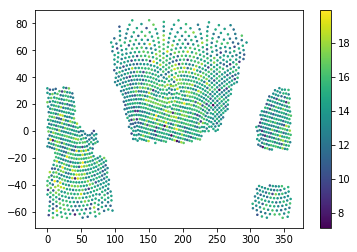

In [26]:
I = np.flatnonzero(tiles_ann.brightest_focus_1_a[:,0])
plt.scatter(tiles.ra[I], tiles.dec[I], c=tiles_ann.brightest_focus_1_a[I,0], marker='.', s=9);
plt.colorbar();

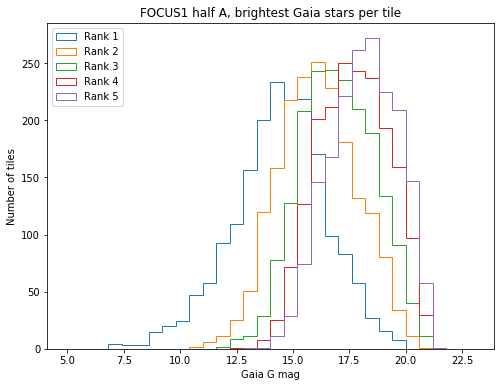

In [33]:
plt.figure(figsize=(8,6))
mx = 5
ha = dict(histtype='step', range=(mx,23), bins=30)
for j in range(5):
    J, = np.nonzero(tiles_ann.brightest_focus_1_a[I,j])
    plt.hist(np.maximum(mx, tiles_ann.brightest_focus_1_a[I[J],j]), label='Rank %i'%(j+1), **ha);
plt.title('FOCUS1 half A, brightest Gaia stars per tile')
plt.xlabel('Gaia G mag')
plt.ylabel('Number of tiles')
plt.legend(loc='upper left');
plt.savefig('focus1a-brightest.png')

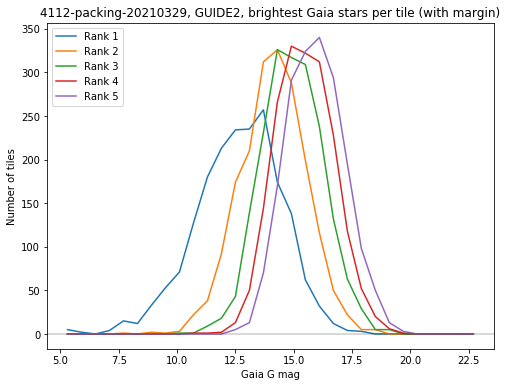

In [41]:
plt.figure(figsize=(8,6))
mx = 5
#ha = dict(histtype='step', range=(mx,23), bins=30)
for j in range(5):
    c = 'brightest_guide_2_margin'
    J, = np.nonzero(tiles_ann.get(c)[I,j])
    n,e = np.histogram(np.maximum(mx, tiles_ann.get(c)[I[J],j]), bins=30, range=(mx,23))
    emid = (e[:-1]+e[1:])/2.
    p = plt.plot(emid, n, '-', label='Rank %i'%(j+1))
    #c = 'brightest_guide_2_margin'
    #n,e = np.histogram(np.maximum(mx, tiles_ann.get(c)[I[J],j]), bins=30, range=(mx,23))
    #plt.plot(emid, n, '--', color=p[0].get_color(), label='Rank %i (w / margin)'%(j+1))
plt.axhline(0., color='k', alpha=0.2)
plt.title('%s, GUIDE2, brightest Gaia stars per tile (with margin)' % tag)
plt.xlabel('Gaia G mag')
plt.ylabel('Number of tiles')
plt.legend(loc='upper left');
plt.savefig('guide2-brightest.png')

In [29]:
tiles_ann.about()

tabledata object with 94576 rows and 21 columns:
   brightest_focus_1_a (<class 'numpy.ndarray'>) shape (94576, 10) dtype float32
   brightest_focus_1_b (<class 'numpy.ndarray'>) shape (94576, 10) dtype float32
   brightest_focus_4_a (<class 'numpy.ndarray'>) shape (94576, 10) dtype float32
   brightest_focus_4_b (<class 'numpy.ndarray'>) shape (94576, 10) dtype float32
   brightest_focus_6_a (<class 'numpy.ndarray'>) shape (94576, 10) dtype float32
   brightest_focus_6_b (<class 'numpy.ndarray'>) shape (94576, 10) dtype float32
   brightest_focus_9_a (<class 'numpy.ndarray'>) shape (94576, 10) dtype float32
   brightest_focus_9_b (<class 'numpy.ndarray'>) shape (94576, 10) dtype float32
   brightest_guide_0 (<class 'numpy.ndarray'>) shape (94576, 10) dtype float32
   brightest_guide_0_margin (<class 'numpy.ndarray'>) shape (94576, 10) dtype float32
   brightest_guide_2 (<class 'numpy.ndarray'>) shape (94576, 10) dtype float32
   brightest_guide_2_margin (<class 'numpy.ndarray'>) shape

In [30]:
len(tiles)

94576

In [31]:
tiles.add_columns_from(tiles_ann)

Not copying existing column centerid


In [32]:
tiles.writeto('tiles-%s-decorated-brightest.fits' % tag)